# Importing Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [ ]:
import classes.file_loader as file_loader
import classes.arma as arma

# Data Preprocessing

## Loading Files

In [22]:
file_path = "" # File is in the parent file
file_name = "Index.xlsx"

FileLoader = file_loader.FileLoader(file_path, file_name)

In [23]:
classic_sheet_name, precarity_sheet_name = "Classique","Précarité"

classic_raw_df, preacarity_raw_df = FileLoader.load_file(classic_sheet_name, precarity_sheet_name)

c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\classes\file_loader.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  classic_raw_df.fillna(method = "ffill", inplace=True)
c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\classes\file_loader.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precarity_raw_df.fillna(method = "ffill", inplace=True)


In [24]:
classic_raw_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-05-01,7.321166
2,2023-05-08,7.360211
3,2023-05-15,7.380000
4,2023-05-22,7.400000
...,...,...
85,2024-12-16,7.810000
86,2024-12-23,7.970000
87,2024-12-30,7.970000
88,2025-01-06,7.970000


In [25]:
preacarity_raw_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-05-01,7.460184
2,2023-05-08,7.465385
3,2023-05-15,7.465385
4,2023-05-22,7.473191
...,...,...
85,2024-12-16,9.720000
86,2024-12-23,9.820000
87,2024-12-30,9.820000
88,2025-01-06,10.030000


## Augmented dataframes

In [26]:
augmented_classic_df = FileLoader.interpolate_dataframe(classic_raw_df)
augmented_classic_df.to_csv("augmented_classic_df.csv", index=False)
augmented_classic_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-04-25,7.187930
2,2023-04-26,7.195880
3,2023-04-27,7.172434
4,2023-04-28,7.337542
...,...,...
446,2025-01-07,7.967259
447,2025-01-08,8.002481
448,2025-01-09,8.026811
449,2025-01-10,8.023866


In [27]:
augmented_precarity_df = FileLoader.interpolate_dataframe(preacarity_raw_df)
augmented_precarity_df.to_csv("augmented_precarity_df.csv", index=False)
augmented_precarity_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-04-25,7.414705
2,2023-04-26,7.273164
3,2023-04-27,7.497408
4,2023-04-28,7.452413
...,...,...
446,2025-01-07,9.774799
447,2025-01-08,10.066254
448,2025-01-09,10.256751
449,2025-01-10,10.558149


## Plotting the augmented dataframes 

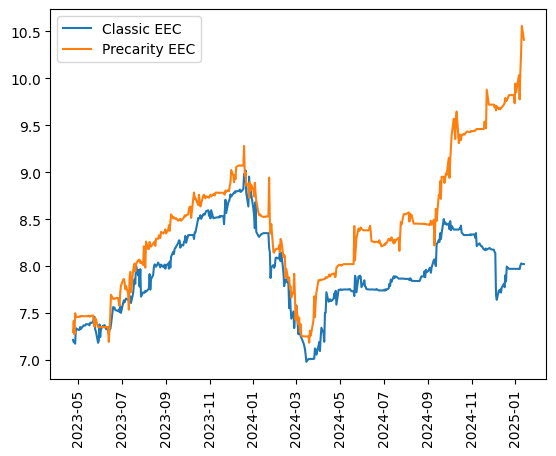

In [28]:
plt.figure()

plt.plot(augmented_classic_df["Date"], augmented_classic_df["SPOT"], label = "Classic EEC")
plt.plot(augmented_precarity_df["Date"], augmented_precarity_df["SPOT"], label = "Precarity EEC")
plt.legend()
plt.xticks(rotation = 90)

plt.show()

# Data forecasting

## Tests

### Stationnarity

From the Graph we can clearly see that the data is non stationnary. We will first differentiate the time series and check weither it has 

In [29]:
classic_df = augmented_classic_df.copy()
classic_df["Delta"] = classic_df["SPOT"] - classic_df["SPOT"].shift(1)
classic_df.dropna(inplace = True)
classic_df

,Date,SPOT,Delta
1,2023-04-25,7.187930,-0.024786
2,2023-04-26,7.195880,0.007950
3,2023-04-27,7.172434,-0.023446
4,2023-04-28,7.337542,0.165108
5,2023-05-01,7.321166,-0.016377
...,...,...,...
446,2025-01-07,7.967259,-0.002741
447,2025-01-08,8.002481,0.035223
448,2025-01-09,8.026811,0.024330
449,2025-01-10,8.023866,-0.002946


In [30]:
# Run ADF: regression='c' includes a constant; autolag='AIC' chooses lag automatically
result = adfuller(classic_df["Delta"], regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_values, icbest = result

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Result: reject unit root -> series is stationary (at 5% level).")
else:
    print("Result: fail to reject unit root -> series is non-stationary.")

p-value: 2.711860234388587e-13
Result: reject unit root -> series is stationary (at 5% level).


In [31]:
precarity_df = augmented_precarity_df.copy()
precarity_df["Delta"] = precarity_df["SPOT"] - precarity_df["SPOT"].shift(1)
precarity_df.dropna(inplace = True)
precarity_df

,Date,SPOT,Delta
1,2023-04-25,7.414705,0.117923
2,2023-04-26,7.273164,-0.141541
3,2023-04-27,7.497408,0.224244
4,2023-04-28,7.452413,-0.044995
5,2023-05-01,7.460184,0.007770
...,...,...,...
446,2025-01-07,9.774799,-0.255201
447,2025-01-08,10.066254,0.291455
448,2025-01-09,10.256751,0.190496
449,2025-01-10,10.558149,0.301398


In [32]:
# Run ADF: regression='c' includes a constant; autolag='AIC' chooses lag automatically
result = adfuller(precarity_df["Delta"], regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_values, icbest = result

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Result: reject unit root -> series is stationary (at 5% level).")
else:
    print("Result: fail to reject unit root -> series is non-stationary.")

p-value: 1.9899448155205687e-16
Result: reject unit root -> series is stationary (at 5% level).


## ARIMA

After having checked that the tiume series is stationnary, we aim at bulding

## LSTM

## GRU